In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, NMF
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import minmax_scale

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
X_train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
X_train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')

# Principal Component Analysis (PCA)

In [3]:
def pca(X_transaction, X_identity):
    X_transaction_V = X_transaction.iloc[:, 54:]
    X_transaction_minus_V = X_transaction.drop(columns=X_transaction_V.columns, inplace=False)
    null_cols = []
    for col in X_transaction_V.columns:
        if (X_transaction_V[col].isnull().sum() / X_transaction_V.shape[0]) > 0.8:
            null_cols.append(col)
    X_transaction_nan_removed = X_transaction_V.drop(null_cols, axis=1)
    X_nan_filled = X_transaction_nan_removed.fillna(-1)
    scaler = StandardScaler()
    scaler.fit(X_nan_filled)
    X_transaction_V_scaled = scaler.transform(X_nan_filled)
    pca = PCA(n_components=85)
    X_pca = pca.fit_transform(X_transaction_V_scaled)
    pca_columns = []
    for i in range(X_pca.shape[1]):
        pca_columns.append("V" + str(i+1) + "_new")
    X_pca_df = pd.DataFrame(X_pca, index=X_nan_filled.index, columns=pca_columns)
    X_transaction_full = X_pca_df.merge(X_transaction_minus_V, how='left', left_index=True, right_index=True)
    X = X_transaction_full.merge(X_identity, how='left', left_index=True, right_index=True)
    return X

# Preprocessing

In [4]:
def data_preprocessing(X):
    email_columns = ['P_emaildomain', 'R_emaildomain']
    X[email_columns] = X[email_columns].fillna(value='EMPTY')
    emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 
          'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 
          'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 
          'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 
          'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
          'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
          'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 
          'juno.com': 'other', 'icloud.com': 'apple'}
    us_emails = ['gmail', 'net', 'edu']
    
    # Reference: https://www.kaggle.com/tolgahancepel/lightgbm-single-model-and-feature-engineering
    for c in email_columns:
        X[c + '_bin'] = X[c].map(emails)
        X[c + '_suffix'] = X[c].map(lambda x: str(x).split('.')[-1])
        X[c + '_suffix'] = X[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    
    id_n_d_columns = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'D1', 'D3', 'D5', 
               'D6', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'D4', 'D15']
    for col in id_n_d_columns:
        X[col] = (minmax_scale(X[col], feature_range=(0, 1)))
        X[col] = X[col].fillna(-1)
    
    for i in X.columns:
        if X[i].dtype == 'object': 
            label = LabelEncoder()
            label.fit(list(X[i].values))
            X[i] = label.transform(list(X[i].values))
    
    categorical_data = X.select_dtypes(include=['object'])
    categorical_data_nan_filled = categorical_data.fillna('EMPTY')
    numerical_data = X._get_numeric_data()
    numerical_data_nan_filled = numerical_data.fillna(-1)
    X = pd.concat([numerical_data_nan_filled, categorical_data_nan_filled], axis=1) 
    return X

In [5]:
X_train_pca = pca(X_train_transaction, X_train_identity)
y_train = X_train_pca['isFraud']
X_train_pca.drop(columns=['isFraud'], inplace=True)

In [6]:
X_train = data_preprocessing(X_train_pca)

In [7]:
X_train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


# Checking Imbalance

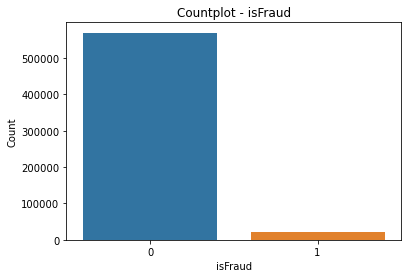

In [8]:
plt.figure(1)
sns.countplot(x='isFraud', data=X_train_transaction)
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.title('Countplot - isFraud')
plt.show()

# Using SMOTE Technique for Balancing

In [9]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

In [10]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Logistic Regression Without Balancing

In [11]:
log_clf_imbalanced = LogisticRegression().fit(X_train_imbalanced, y_train_imbalanced)

In [12]:
y_predicted_imbalanced = log_clf_imbalanced.predict(X_test_imbalanced)

In [13]:
accuracy_log_imbalanced = accuracy_score(y_test_imbalanced, y_predicted_imbalanced)
print("Accuracy Score of Logistic Regression on Testing Data (Imbalanced)", accuracy_log_imbalanced)

Accuracy Score of Logistic Regression on Testing Data (Imbalanced) 0.9642079001140199


In [14]:
y_predicted_imbalanced_train = log_clf_imbalanced.predict(X_train_imbalanced)

In [15]:
accuracy_log_imbalanced_train = accuracy_score(y_train_imbalanced, y_predicted_imbalanced_train)
print("Accuracy Score of Logistic Regression on Training Data (Imbalanced)", accuracy_log_imbalanced_train)

Accuracy Score of Logistic Regression on Training Data (Imbalanced) 0.965353744030887


In [16]:
print("Classification Report of Logistic Regression on Testing Data (Imbalanced)")
print(classification_report(y_test_imbalanced, y_predicted_imbalanced))

Classification Report of Logistic Regression on Testing Data (Imbalanced)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    170821
           1       0.00      0.00      0.00      6341

    accuracy                           0.96    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.96      0.95    177162



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


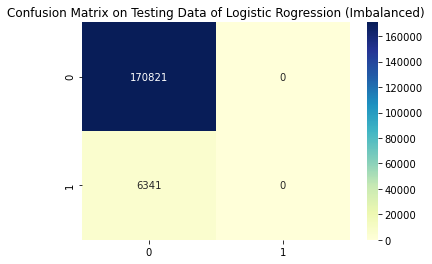

In [17]:
plt.figure(2)
plt.title('Confusion Matrix on Testing Data of Logistic Rogression (Imbalanced)')
sns.heatmap(confusion_matrix(y_test_imbalanced, y_predicted_imbalanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

# Logistic Regression With Balancing

In [18]:
log_clf_balanced = LogisticRegression().fit(X_train_balanced, y_train_balanced)

In [19]:
y_predicted_balanced = log_clf_balanced.predict(X_test_balanced)

In [20]:
accuracy_log_balanced = accuracy_score(y_test_balanced, y_predicted_balanced)
print("Accuracy Score of Logistic Regression on Testing Data (Balanced)" , accuracy_log_balanced)

Accuracy Score of Logistic Regression on Testing Data (Balanced) 0.6529961073562486


In [21]:
y_predicted_balanced_train = log_clf_balanced.predict(X_train_balanced)

In [22]:
accuracy_log_balanced_train = accuracy_score(y_train_balanced, y_predicted_balanced_train)
print("Accuracy Score of Logistic Regression on Training Data (Balanced)", accuracy_log_balanced_train)

Accuracy Score of Logistic Regression on Training Data (Balanced) 0.6534825219001111


In [23]:
print("Classification Report of Logistic Regression on Testing Data (Balanced)")
print(classification_report(y_test_balanced, y_predicted_balanced))

Classification Report of Logistic Regression on Testing Data (Balanced)
              precision    recall  f1-score   support

           0       0.62      0.78      0.69    170944
           1       0.70      0.53      0.60    170983

    accuracy                           0.65    341927
   macro avg       0.66      0.65      0.65    341927
weighted avg       0.66      0.65      0.65    341927



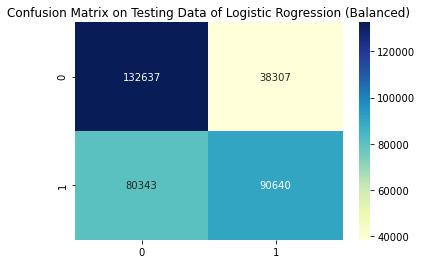

In [24]:
plt.figure(3)
plt.title('Confusion Matrix on Testing Data of Logistic Rogression (Balanced)')
sns.heatmap(confusion_matrix(y_test_balanced, y_predicted_balanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

# XGBoost without Balancing

In [27]:
xgb_model_imbalanced = XGBClassifier()
xgb_model_imbalanced.fit(X_train_imbalanced, y_train_imbalanced)
y_predicted_imbalanced = xgb_model_imbalanced.predict(X_test_imbalanced)

In [28]:
accuracy_xgb_imbalanced = accuracy_score(y_test_imbalanced, y_predicted_imbalanced)
print('Accuracy Score of XGBoost on Testing Data (Imbalanced)', accuracy_xgb_imbalanced)

Accuracy Score of XGBoost on Testing Data (Imbalanced) 0.9800013546923155


In [29]:
y_predicted_imbalanced_train = xgb_model_imbalanced.predict(X_train_imbalanced)

In [30]:
accuracy_xgb_imbalanced_train = accuracy_score(y_train_imbalanced, y_predicted_imbalanced_train)
print('Accuracy Score of XGBoost on Training Data (Imbalanced)', accuracy_xgb_imbalanced_train)

Accuracy Score of XGBoost on Training Data (Imbalanced) 0.9849653343912835


In [31]:
print("Classification Report of XGBoost on Testing Data (Imbalanced)")
print(classification_report(y_test_imbalanced, y_predicted_imbalanced))

Classification Report of XGBoost on Testing Data (Imbalanced)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    170821
           1       0.91      0.49      0.64      6341

    accuracy                           0.98    177162
   macro avg       0.94      0.74      0.81    177162
weighted avg       0.98      0.98      0.98    177162



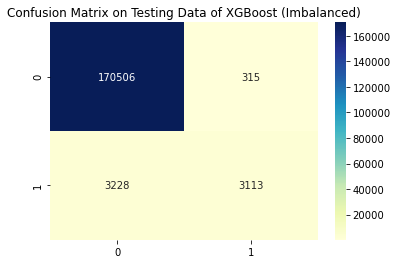

In [32]:
plt.figure(4)
plt.title('Confusion Matrix on Testing Data of XGBoost (Imbalanced)')
sns.heatmap(confusion_matrix(y_test_imbalanced, y_predicted_imbalanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

# XGBoost with Weight Balancing

In [33]:
xgb_model_weight_balanced = XGBClassifier(scale_pos_weight=y_train_imbalanced.value_counts()[0]/y_train_imbalanced.value_counts()[1])
xgb_model_weight_balanced.fit(X_train_imbalanced, y_train_imbalanced)
y_predicted_weight_balanced = xgb_model_weight_balanced.predict(X_test_imbalanced)

In [34]:
accuracy_xgb_weight_balanced = accuracy_score(y_test_imbalanced, y_predicted_weight_balanced)
print('Accuracy Score of XGBoost on Testing Data (Weight Balanced)', accuracy_xgb_weight_balanced)

Accuracy Score of XGBoost on Testing Data (Weight Balanced) 0.9277553877242298


In [35]:
y_predicted_weight_balanced_train = xgb_model_weight_balanced.predict(X_train_imbalanced)

In [36]:
accuracy_xgb_weight_balanced_train = accuracy_score(y_train_imbalanced, y_predicted_weight_balanced_train)
print('Accuracy Score of XGBoost on Training Data (Weight Balanced)', accuracy_xgb_weight_balanced_train)

Accuracy Score of XGBoost on Training Data (Weight Balanced) 0.9358359661133394


In [37]:
print("Classification Report of XGBoost on Testing Data (Weight Balanced)")
print(classification_report(y_test_imbalanced, y_predicted_weight_balanced))

Classification Report of XGBoost on Testing Data (Weight Balanced)
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    170821
           1       0.31      0.80      0.44      6341

    accuracy                           0.93    177162
   macro avg       0.65      0.87      0.70    177162
weighted avg       0.97      0.93      0.94    177162



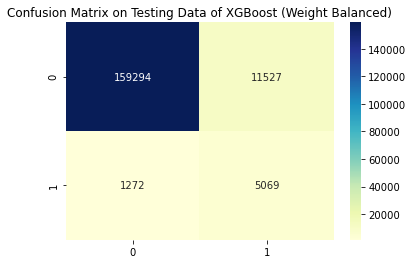

In [38]:
plt.figure(5)
plt.title('Confusion Matrix on Testing Data of XGBoost (Weight Balanced)')
sns.heatmap(confusion_matrix(y_test_imbalanced, y_predicted_weight_balanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

# XGBoost with SMOTE Balancing

In [39]:
xgb_model_balanced = XGBClassifier()
xgb_model_balanced.fit(X_train_balanced, y_train_balanced)
y_predicted_balanced = xgb_model_balanced.predict(X_test_balanced)

In [40]:
accuracy_xgb_balanced = accuracy_score(y_test_balanced, y_predicted_balanced)
print('Accuracy Score of XGBoost on Testing Data (Balanced)', accuracy_xgb_balanced)

Accuracy Score of XGBoost on Testing Data (Balanced) 0.9864123043807597


In [41]:
y_predicted_balanced_train = xgb_model_balanced.predict(X_train_balanced)

In [42]:
accuracy_xgb_balanced_train = accuracy_score(y_train_balanced, y_predicted_balanced_train)
print('Accuracy Score of XGBoost on Training Data (Balanced)', accuracy_xgb_balanced_train)

Accuracy Score of XGBoost on Training Data (Balanced) 0.9880901498695832


In [43]:
print("Classification Report of XGBoost on Testing Data (Balanced)")
print(classification_report(y_test_balanced, y_predicted_balanced))

Classification Report of XGBoost on Testing Data (Balanced)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    170944
           1       0.99      0.98      0.99    170983

    accuracy                           0.99    341927
   macro avg       0.99      0.99      0.99    341927
weighted avg       0.99      0.99      0.99    341927



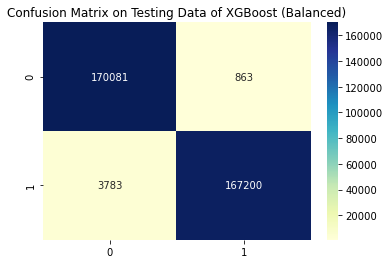

In [44]:
plt.figure(5)
plt.title('Confusion Matrix on Testing Data of XGBoost (Balanced)')
sns.heatmap(confusion_matrix(y_test_balanced, y_predicted_balanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

# LightGBM without Balancing

In [47]:
lgbm_model_imbalanced = lgbm.LGBMClassifier().fit(X_train_imbalanced, y_train_imbalanced)
y_predicted_imbalanced = lgbm_model_imbalanced.predict(X_test_imbalanced)

NameError: name 'lgbm' is not defined

In [ ]:
accuracy_lgbm_imbalanced = accuracy_score(y_test_imbalanced, y_predicted_imbalanced)
print('Accuracy Score of LightGBM on Testing Data (Imbalanced)', accuracy_lgbm_imbalanced)

In [ ]:
y_predicted_imbalanced_train = lgbm_model_imbalanced.predict(X_train_imbalanced)

In [ ]:
accuracy_lgbm_imbalanced_train = accuracy_score(y_train_imbalanced, y_predicted_imbalanced_train)
print('Accuracy Score of LightGBM on Training Data (Imbalanced)', accuracy_lgbm_imbalanced_train)

In [ ]:
print("Classification Report of LightGBM on Testing Data (Imbalanced)")
print(classification_report(y_test_imbalanced, y_predicted_imbalanced))

In [ ]:
plt.figure(4)
plt.title('Confusion Matrix on Testing Data of LightGBM (Imbalanced)')
sns.heatmap(confusion_matrix(y_test_imbalanced, y_predicted_imbalanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

# LightGBM with Weight Balancing

In [ ]:
lgbm_model_weight_balanced = lgbm.LGBMClassifier(is_unbalance=True)
lgbm_model_weight_balanced.fit(X_train_imbalanced, y_train_imbalanced)
y_predicted_weight_balanced = lgbm_model_weight_balanced.predict(X_test_imbalanced)

In [ ]:
accuracy_lgbm_weight_balanced = accuracy_score(y_test_imbalanced, y_predicted_weight_balanced)
print('Accuracy Score of LightGBM on Testing Data (Weight Balanced)', accuracy_lgbm_weight_balanced)

In [ ]:
y_predicted_weight_balanced_train = lgbm_model_weight_balanced.predict(X_train_imbalanced)

In [ ]:
accuracy_lgbm_weight_balanced_train = accuracy_score(y_train_imbalanced, y_predicted_weight_balanced_train)
print('Accuracy Score of LightGBM on Training Data (Weight Balanced)', accuracy_lgbm_weight_balanced_train)

In [ ]:
print("Classification Report of LightGBM on Testing Data (Weight Balanced)")
print(classification_report(y_test_imbalanced, y_predicted_weight_balanced))

In [ ]:
plt.figure(5)
plt.title('Confusion Matrix on Testing Data of LightGBM (Weight Balanced)')
sns.heatmap(confusion_matrix(y_test_imbalanced, y_predicted_weight_balanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

# LightGBM with SMOTE Balancing

In [ ]:
lgbm_model_balanced = lgbm.LGBMClassifier().fit(X_train_balanced, y_train_balanced)
y_predicted_balanced = lgbm_model_balanced.predict(X_test_balanced)

In [ ]:
accuracy_lgbm_balanced = accuracy_score(y_test_balanced, y_predicted_balanced)
print('Accuracy Score of LightGBM on Testing Data (Balanced)', accuracy_lgbm_balanced)

In [ ]:
y_predicted_balanced_train = lgbm_model_balanced.predict(X_train_balanced)

In [ ]:
accuracy_lgbm_balanced_train = accuracy_score(y_train_balanced, y_predicted_balanced_train)
print('Accuracy of LightGBM on Training Data (Balanced)', accuracy_lgbm_balanced_train)

In [ ]:
print("Classification Report of LightGBM on Testing Data (Balanced)")
print(classification_report(y_test_imbalanced, y_predicted_balanced))

In [ ]:
plt.figure(5)
plt.title('Confusion Matrix on Testing Data of LightGBM (Balanced)')
sns.heatmap(confusion_matrix(y_test_balanced, y_predicted_balanced), fmt='d', cmap='YlGnBu', annot=True)
plt.show()

In [ ]:
y_scores = lgbm_model_weight_balanced.predict_proba(X_test_balanced)[:,-1]

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test_balanced, y_scores)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(9, figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.00])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve of XGBoost', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()